In [1]:
from __future__ import print_function, unicode_literals, with_statement, absolute_import, generators, nested_scopes, division
import os
import subprocess
from pyspark.sql import SparkSession

runLocal = True

if runLocal:
    spark  = SparkSession.builder.master('local').appName('songs').getOrCreate()
else:
    #p = subprocess.Popen(['sinteractive', '--partition=broadwl', '--cpus-per-task=10', '--time=00:30:00'], stdout=subprocess.PIPE, shell = True)
    #print(p.stdout.read())
    # start spark master program on this machine and register worker nodes
    os.system('start-spark-slurm.sh&') # use & to put it into background
    # get ip address of this machine
    ip = os.popen('hostname -i').read().strip('\n')
    # change 'local' to be ip of master node
    spark = SparkSession.builder \
        .master('spark://' + ip + ':7077') \
        .appName('minst') \
        .getOrCreate()
    print('Spark Session web UI: http://{}:4040'.format(ip))

In [19]:
import matplotlib.pyplot as plt
import seaborn
import scipy.io
import numpy as np
import seaborn
import sklearn.decomposition
import sklearn.manifold
import scipy.linalg
import math
import collections
import pandas
import IPython.display

np.set_printoptions(suppress=True)
%matplotlib inline

from operator import add
import pyspark.sql.functions
import pyspark.mllib.clustering
import pyspark.mllib.classification
from pyspark.mllib.classification import LabeledPoint
from pyspark.mllib.linalg import  SparseVector, DenseMatrix, DenseVector

import re
import functools

# Part 1: Song Embeddings

## Sections a), b), c)
Loading results

In [4]:
songVectors = 'GloVe/song-vectors.txt'
songVocab = 'GloVe/song-vocab.txt'

songToTagFile = '/project/cmsc25025/playlist/song-to-tags.txt'
tagIDFile = '/project/cmsc25025/playlist/tag_hash.txt'
songIDFile = '/project/cmsc25025/playlist/song_hash.txt'

In [5]:
def loadGloVeVects(fname):
    with open(fname, 'r') as f:
        vectors = collections.OrderedDict()
        for line in f:
            vals = line.rstrip().split(' ')
            try:
                vectors[int(vals[0])] = np.array([float(x) for x in vals[1:]])
            except ValueError:
                break
    return vectors
songRDD = spark.sparkContext.parallelize(loadGloVeVects(songVectors).items())

In [6]:
with open(tagIDFile) as f:
    idToTag = collections.OrderedDict()
    for line in f:
        idVal, tag = line.strip().split(', ')
        idToTag[int(idVal)] = tag

In [7]:
with open(songIDFile) as f:
    idToSong = {}
    idToAuth = {}
    for line in f:
        idVal, name, auth = line.strip().split('\t')
        idToSong[int(idVal)] = name
        idToAuth[int(idVal)] = auth

In [8]:
with open(songToTagFile) as f:
    songToTagID = {}
    songToTag = {}
    songToTagVect = {}
    for line in f:
        idVal, tags = line.strip().split('\t')
        songToTagID[int(idVal)] = []
        songToTag[int(idVal)] = []
        songToTagVect[int(idVal)] = np.zeros(len(idToTag))
        if tags == '#':
            pass
        else:
            for tag in tags.split(','):
                songToTagID[int(idVal)].append(tag)
                songToTag[int(idVal)].append(idToTag[int(tag)])
                songToTagVect[int(idVal)][int(tag)] = 1

## Section d)

In [9]:
def computeTagClusters(rd, k):
    clusters = pyspark.mllib.clustering.KMeans.train(rd.map(lambda x: x[1]),
                                                     k,
                                                     maxIterations=50,
                                                     initializationMode="random")
    pointsRDD = rd.map(lambda x : (clusters.predict(x[1]), songToTag[x[0]], songToTagVect[x[0]]))
    clusterVects = {k: v for k, v in pointsRDD.map(lambda x: (x[0], x[2])).reduceByKey(add).collect()}
    clusterTop10s = {"Cluster {}".format(k) : [idToTag[i] for i in v.argsort()[-10:][::-1]] for k, v in clusterVects.items()}
    df = pandas.DataFrame(clusterTop10s)
    df.index.name = 'Rank'
    return df

In [9]:
computeTagClusters(songRDD, 5)

,Cluster 0,Cluster 1,Cluster 2,Cluster 3,Cluster 4
Rank,,,,,
0,pop,rock,rock,pop,country
1,dance,pop,favorites,favorites,my favorite
2,hip-hop,favorites,pop,rock,classic country
3,rnb,male vocalists,male vocalists,love,great song
4,hip hop,love,american,male vocalists,beautiful
5,love,classic rock,alternative,american,male vocalists
6,party,american,awesome,pop rock,favorites
7,catchy,awesome,love,awesome,love
8,rap,oldies,alternative rock,alternative,pop


These clusters look reasonable, they are mostly distinct collections (approximately hip-hop, oldies, alternative, love, country). You do have look past the tags common to many songs like 'pop' as these are common to all. 

## Section e)

In [10]:
def embedVis(rd, idDict, nVects = 1000):
    tsne = sklearn.manifold.TSNE(n_components=2, random_state=0)
    W = np.stack(rd.map(lambda x: x[1]).collect())
    Y = tsne.fit_transform(W[:nVects,:])
    fig, ax = plt.subplots(figsize = (20, 20))
    ax.scatter(Y[:, 0], Y[:, 1])
    for label, x, y in zip(rd.map(lambda x: idDict[x[0]]).collect(), Y[:, 0], Y[:, 1]):
        ax.annotate(label, xy=(x, y), xytext=(0, 0), textcoords='offset points')
    plt.show()

/software/python-2.7.12-el7-x86_64/lib/python2.7/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family [u'sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


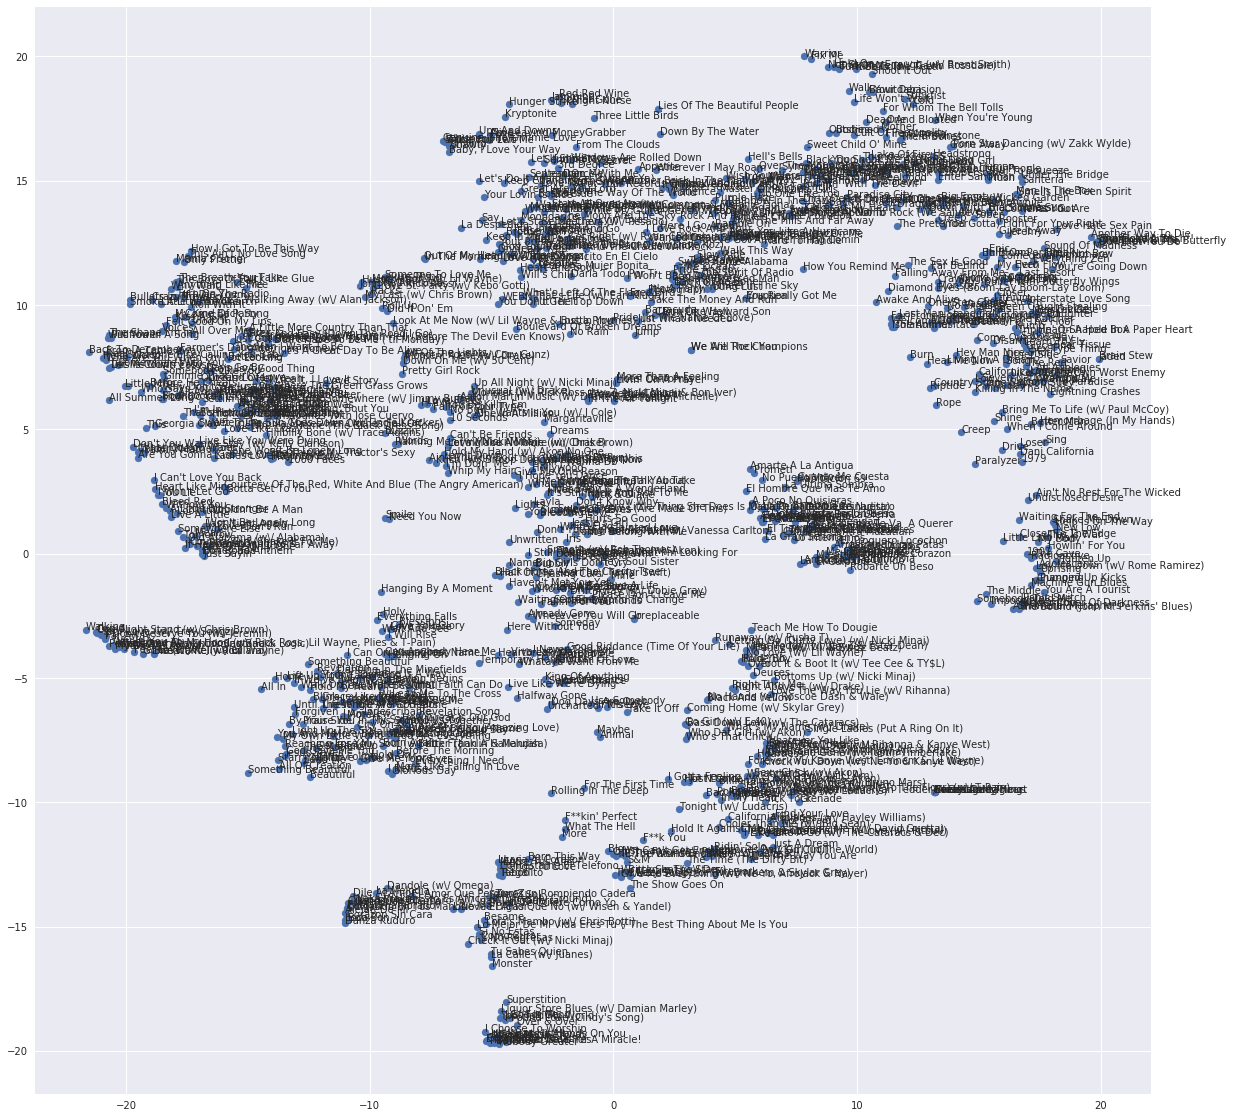

In [11]:
embedVis(songRDD, idToSong)

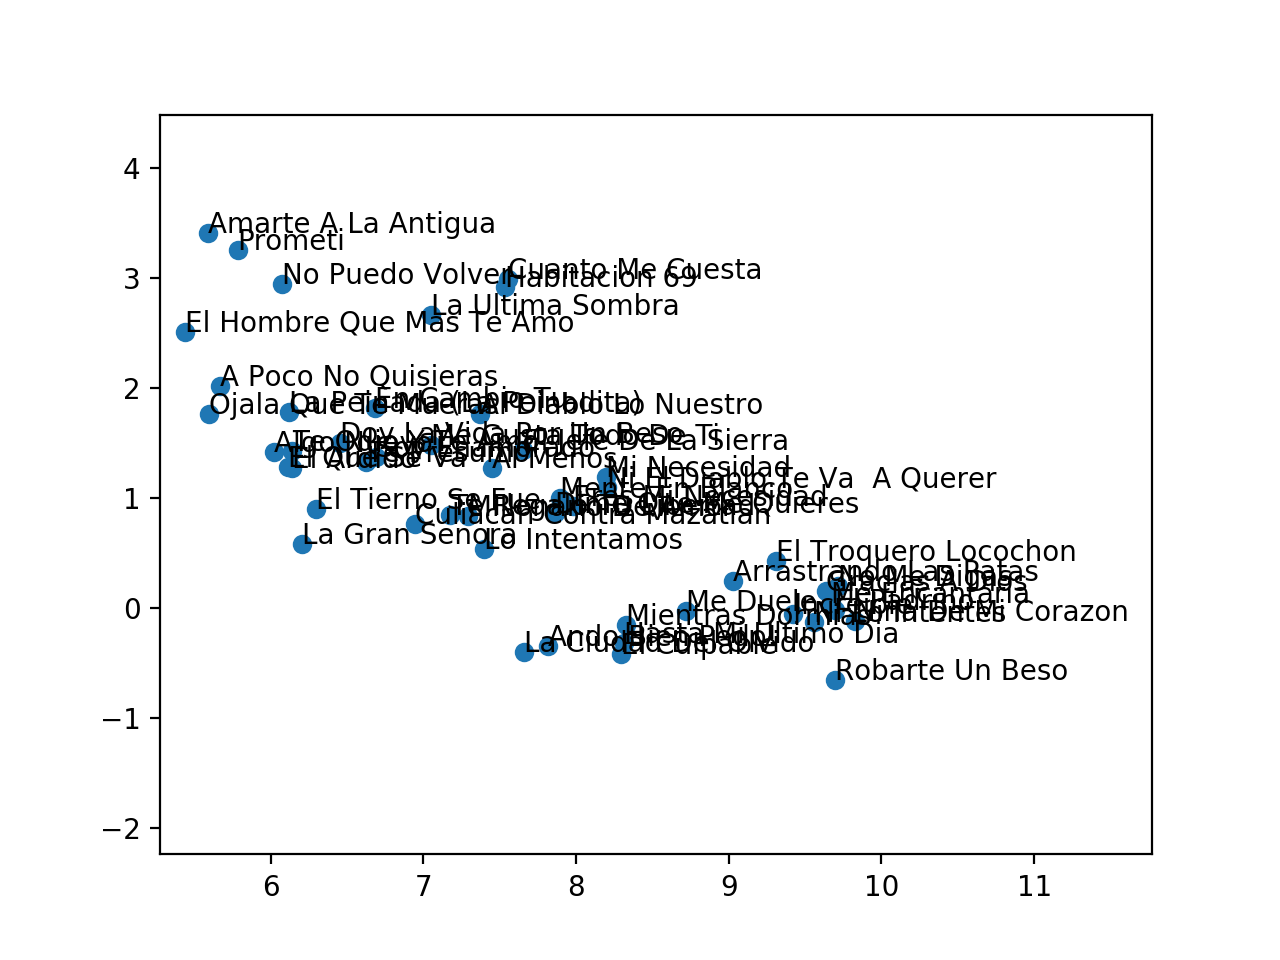

In [20]:
IPython.display.Image(filename='songs.png') 

By using the dynamic visual we wer able to find a cluster of Spanish songs. The language is likely what caused them to be so closely clustered.

# Part 2: Artist Embeddings

## Sections a), b), c)
Loading results

In [12]:
artistVectors = 'GloVe/artist-vectors.txt'
artistVocab = 'GloVe/artist-vocab.txt'

artistIDFile = '/project/cmsc25025/playlist/artist_hash.txt'

In [13]:
with open(artistIDFile) as f:
    idToAuth = {}
    authToId = {}
    for line in f:
        idVal, auth = line.strip().split('\t')
        idToAuth[int(idVal)] = auth
        authToId[auth] = int(idVal)

In [14]:
authVects = loadGloVeVects(artistVectors)

In [15]:
artistRDD = spark.sparkContext.parallelize(loadGloVeVects(artistVectors).items())

## Section d)

In [16]:
def findClosest(auth, vects, n = 5):
    X = np.stack(vects.values())
    authVec = vects[authToId[auth]]
    dists = X - authVec
    topn = (dists * dists).sum(axis =1).argsort()[-n:][::-1]
    return [idToAuth[i] for i in topn]

In [17]:
targetAuths = ['The Beatles', 'The Red Hot Chili Peppers', 'Usher']

for auth in targetAuths:
    print("The top 5 closests artists to '{}' are:".format(auth))
    print('\n'.join(findClosest(auth, authVects)))
    print()

The top 5 closests artists to 'The Beatles' are:
Everette Harp
Ohio Express
Soul For Real
Nirvana
Frankie Ballard

The top 5 closests artists to 'The Red Hot Chili Peppers' are:
Sonora Santanera
Everette Harp
Ohio Express
Soul For Real
Los Invasores De Nuevo Leon

The top 5 closests artists to 'Usher' are:
Ohio Express
La Quinta Estacion
Gary Allan
Wess Morgan
Pam Tillis



These nearest neighbours do seem to make sense, e.g. popular rock groups are near the beatles.

## Section e)

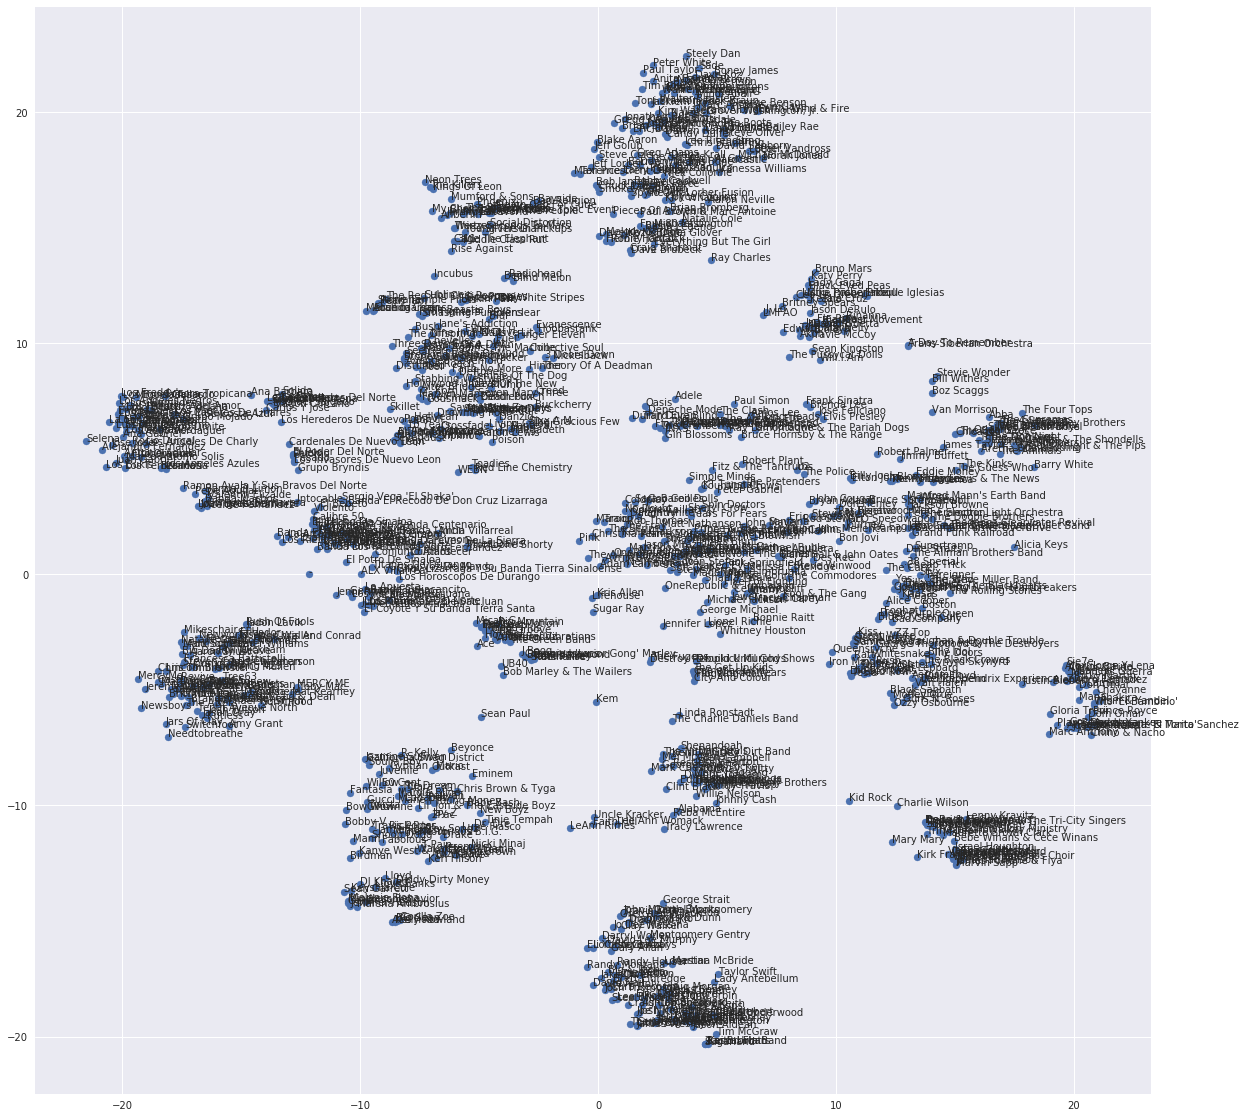

In [18]:
embedVis(artistRDD, idToAuth)

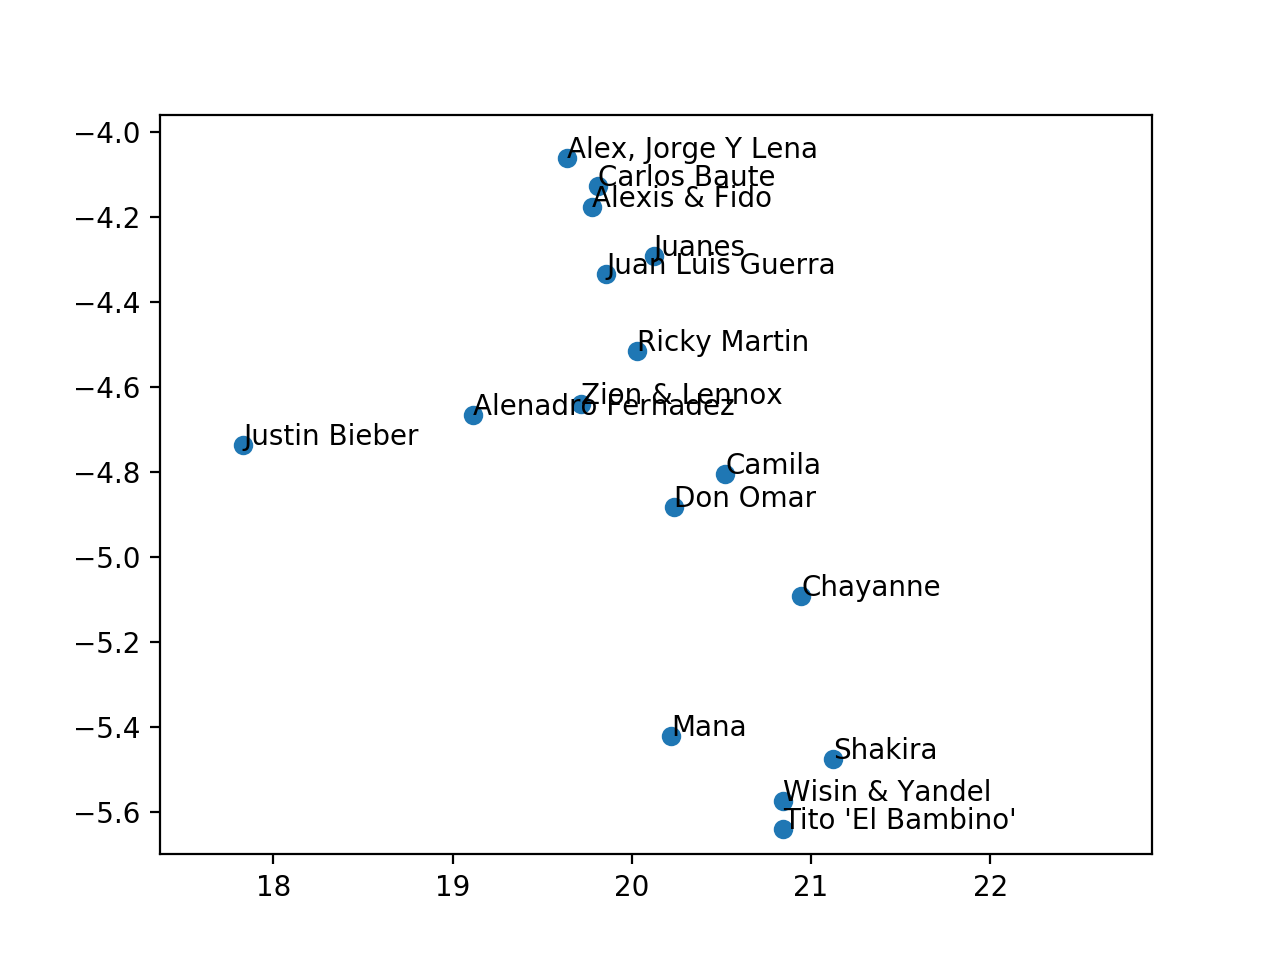

In [21]:
IPython.display.Image(filename='artists.png') 

By using the dynamic visual we wer able to find a cluster of Spanish artists. The language is likely what caused them to be so closely clustered.